# 一、极化数据压缩

## 1. 无损压缩

极化码对于经典的信源无失真编码问题而言，是最优的。针对这个问题，Arikan提出了与信道极化定理相似的信源极化定理，并给出了一类达到信源熵的码。

注意，Arikan的工作是基于“侧信息”的信源压缩问题，也就是说我们在了解随机变量$X$的概率分布的情况下，还了解某个跟$X$有关的随机变量$Y$，我们知道它们的联合概率分布，也知道在每次实验中$Y$的具体取值是多少。侧信息可以为我们提供一部分信息量，残留的不确定度就是$H(X|Y)$。

在实际场景下一般没有所谓的侧信息，此时只需要认为侧信息$Y$与$X$之间相互独立，下文中出现的相关结论和定理依然成立。

### 1.1 信源极化现象

令$X$是一离散无记忆二进制随机变量，另一随机变量$Y$是关于$X$的“侧信息”（side-information）。我们将随机变量二元组$(X,Y)$复制$N$个相互独立的副本，得到随机序列$(X_{1:N},Y_{1:N})$，其中$N=2^n,n\geq 1$是码长。令$U_{1:N}=X_{1:N}\mathbf{G}_N$是由随机序列$X_{1:N}$经过极化变换后得到的序列，显然它也是随机的。

**信源极化定理**：对任意给定的$\delta\in(0,1)$，当$N\to\infty$时，有：

$$\frac{\lvert i\in\{1,\ldots,N\}:H(U_i|Y_{1:N},U_{1:i-1})\in(1-\delta,1]\rvert}{N}\to H(X|Y)$$

以及：

$$\frac{\lvert i\in\{1,\ldots,N\}:H(U_i|Y_{1:N},U_{1:i-1})\in[0,\delta)\rvert}{N}\to 1-H(X|Y)$$

与“极化信道”的概念类似，这里发生极化的也并不是简单的信源，而是所谓的“条件信源”，即已知侧信息$Y_{1:N}$、和前缀随机序列$U_{1:i-1}$的情况下，随机变量$U_i$对应的信源。该定理指出，随着码长的增加，这些信源将要么趋向于均匀分布的信源，要么趋向于几乎完全确定性的信源。

根据条件熵的定义$H(X|Y)=\mathbb{E}_{y}[H(X|Y=y)]$，我们可以准确计算每次实验中的条件概率分布的熵，从而基于Monte-Carlo法对这些条件熵进行估计。以码长$N=1024$、信源熵$H(X)=0.2$为例：

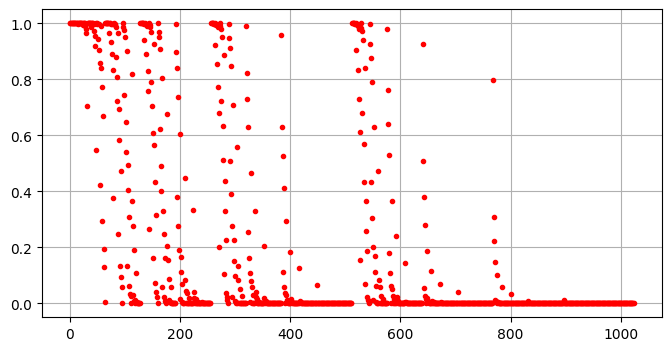

In [1]:
import plcoding
from plcoding.cpp_core.source import prob_polarize
import numpy as np
from matplotlib import pyplot as plt
# 初始化系统参数
N = 1024
px = np.array(plcoding.p_of(0.2))
px_ = np.tile(px, (N, 1))
# 仿真多次取平均
hu = np.zeros(shape=(N,))
for t in range(1000):
    # 生成数据序列
    x = np.random.choice(a=2, p=px, size=(N,))
    # 计算条件概率分布
    pu, u = prob_polarize(px_, x)
    # 计算条件概率分布的熵
    hu += (-pu * np.log2(pu + 1e-100)).sum(axis=1) / 1000
plt.figure(figsize=(8, 4))
plt.plot(hu, 'r.')
plt.grid(); plt.show()

### 1.2 信源极化速率

出于相似性，我们可以粗略地说信源极化的速率与信道极化的速率是一致的。具体来讲，首先我们给出两个随机变量$X$和$Y$之间的Bhattacharyya参数：

$$Z(X|Y) \triangleq 2 \sum_y P_Y(y) \sqrt{P_{X|Y}(0|y) \cdot P_{X|Y}(1|y)}$$

该参数与随机变量的条件熵之间的关系为：
1. $Z(X|Y)^2 \leq H(X|Y)$，表示两者同时趋于$1$；
2. $H(X|Y) \leq \log{(1+Z(X|Y))}$，表示两者同时趋于$0$。

**高熵集**：给定码长$N=2^n,n\geq 1$，随机变量$X_N$，它的侧信息$Y_{1:N}$，以及一个码率$R$，如果集合$\mathcal{H}$满足如下条件，则称它是参数$(N,R)$下的高熵集（high-entropy set）：
1. $\mathcal{H} \subset \{1,\ldots,N\}$，表示它是一个关于索引的集合；
2. $|\mathcal{H}| = \lceil NR \rceil$，表示它是按照码率$R$选取的；
3. $\forall i \in \mathcal{H},\forall j \not\in \mathcal{H}, Z(U_i|Y_{1:N},U_{1:i-1}) \geq Z(U_j|Y_{1:N},U_{1:j-1})$，表示它对应了最大的几个Bhattacharyya参数。

**速率定理**：给定一对满足上述描述的信源$(X,Y)$，固定码率$R > H(X|Y)$不变，固定参数$\beta < \frac{1}{2}$不变，当码长$N$足够大时，总存在一个与$(N,R)$对应的高熵集$\mathcal{H}$，满足：

$$\sum_{i\not\in\mathcal{H}}Z(U_i|Y_{1:N},U_{1:i-1})=\mathcal{O}(2^{-N^\beta})$$

我们可以绘制一下这个趋势：

In [2]:
# 指定码长N，估计Z参数
def get_Z(N, H, tt=100):
    px = np.array(plcoding.p_of(H))
    px_ = np.tile(px, (N, 1))
    Zu = np.zeros(shape=(N,))
    for t in range(tt):
        x = np.random.choice(a=2, p=px, size=(N,))
        pu, u = prob_polarize(px_, x)
        Zu += np.sqrt(np.prod(pu, axis=1)) / tt
    return Zu
# 指定(N, R)，计算低熵集内的Z参数之和
def sum_Z(N, R, H):
    Zu = get_Z(N, H)
    L = N - int(np.ceil(N * R))
    return np.sum(np.partition(Zu, L - 1)[:L])

In [12]:
# 指定信源熵、编码码率的情况，计算不同码长下低熵集的Z参数之和
ns = np.arange(1, 19)
y1 = np.array([sum_Z(N=(1 << n), R=0.4, H=0.3) for n in ns])

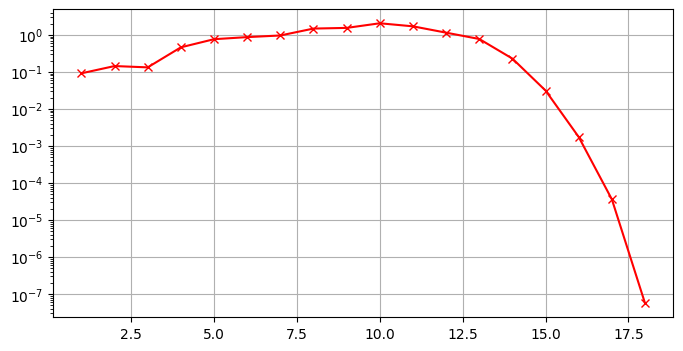

In [16]:
plt.figure(figsize=(8, 4))
plt.semilogy(ns, y1, 'r-x')
plt.grid(); plt.show()

### 1.3 信源极化码

**编码**：设码长$N=2^n,n\geq 1$，在某次实验中各个信源的实现值分别为$x_{1:N}$、$u_{1:N}=x_{1:N}\mathbf{G}_N$以及$y_{1:N}$，那么编码器应当输出由高熵集所指示的子序列$u_{\mathcal{H}}$。

**译码**：译码器在译码开始前已知侧信息$y_{1:N}$，目标是根据编码器的输出序列$u_{\mathcal{H}}$恢复信源序列$x_{1:N}$。为了实现这个任务，首先它将执行SC译码算法对完整序列$u_{1:N}$进行估计：

$$\hat{u}_i \gets \begin{cases}
u_i, &\text{if } i \in \mathcal{H} \\
0, &\text{if } i \not\in \mathcal{H} \text{ and } \frac{\Pr(U_i=0|Y_{1:N}=y_{1:N},U_{1:i-1}=u_{1:i-1})}{\Pr(U_i=1|Y_{1:N}=y_{1:N},U_{1:i-1}=u_{1:i-1})} \geq 1 \\
1, &\text{otherwise}
\end{cases}$$

最后对其进行反变换，即可得到估计值$\hat{x}_{1:N} = \hat{u}_{1:N} \mathbf{G}_N^{-1}$。



### 1.4 简单讨论

根据速率定理，在长码长下，信源极化码在SC译码准则下的错误率以大概$\frac{1}{2^{\sqrt{N}}}$的速度下降，最终趋于$0$。这意味着该方案是信源无失真编码问题的一个可行解。但是，在码长有限的情况下，译码错误是有概率发生的。出于这个原因，这种最初级形式的极化码是不适合用到实际场景下进行数据压缩的，因为我们不可能接受一个“有概率恢复失败”的数据压缩技术。极化码达到理论最优，更多地是一种理论上的结论，并且遗憾的是，目前关于其实用化的研究工作很少。

此外，一定要注意关于极化速率的严格表述，不能有任何偏差。在实验中可能会犯的两个错误是：
1. 随着码长$N$增加，不断调整码率$R$接近信源熵，检查相应的译码错误率；
    - 正确做法：只有在保持码率$R$不变的条件下，当码长$N$足够长时，我们才能找到一个错误率足够低的高熵集；
2. 将子序列$u_{\mathcal{H}}$的长度设置为$|\mathcal{H}|=\lceil NH(X|Y) \rceil$；
    - 正确做法：你不应该将码率设置为$R=H(X|Y)$，必须只能令$R>H(X|Y)$。



### 1.5 实用化改进策略

信源极化码达到无失真编码界，更多的只是一种理论上的行为，不便于实际应用。目前在这方面有一些简单的工作，可以概括为：
1. 每次编码完成后，立即测试一下能否成功译码，如果不能，则将$x_{1:N}$随机重排，然后再次编码、测试，直到成功。这种做法可以在稍微损失一点码率（因为要记录重排操作）的情况下，大幅降低译码错误率，整体性能会有所改善；
2. 每次编码完成后，立即测试一下能否成功译码，如果不能，则将发生错误的位置以及相应的符号值记录下来，存储方式就使用简单的比特表示法。这种做法乍一看可能会带来码率损失，但其实可以对冻结集的定义稍加优化，最终将得到更好的性能；
3. 每次编码完成后，立即执行一轮全冻结的SC译码，并记录出错位置，然后找出最小的出错位对应的条件熵，最后将不小于这个熵值的所有比特位全部输出。相当于直接将原方案拓展为了变长版本。

---

## 2. 有损压缩

极化码对限失真信源压缩问题而言，也是最优的。这项工作由Satish Babu Korada和Rüdiger L. Urbanke完成。

### 2.1 限失真信源压缩问题



### 2.2 

